### Modules needed
conda install -c anaconda numpy<br>
conda install -c anaconda pandas<br>

conda install -c anaconda tensorflow<br>
pip install tensorflow-addons<br>
conda install -c anaconda keras<br>

conda install -c anaconda matplotlib<br>
conda install -c anaconda scikit-learn<br>
conda install -c anaconda seaborn<br>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import argparse
import copy
import collections
import numpy as np
import pandas as pd
from datetime import datetime

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

from data_handler_detection import DataHandler

tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

# Utils
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['sparse_categorical_accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('sparse_categorical_accuracy')
    if 'val_acc' in history.history:
        val_acc = history.history['val_acc']
        plt.plot(epochs, val_acc, 'o-', label='Validation sparse_categorical_accuracy')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

In [3]:
# parse arguments
## general
arg_parser = argparse.ArgumentParser()
arg_parser.add_argument('--working_path', default='.')

## data
arg_parser.add_argument('dataset_name', default='mimic3',
                        help='The data files should be saved in [working_path]/data/[dataset_name] directory.')
arg_parser.add_argument('label_name', default='mortality')
arg_parser.add_argument('--max_timesteps', type=int, default=200, 
                        help='Time series of at most # time steps are used. Default: 200.')
arg_parser.add_argument('--max_timestamp', type=int, default=48*60*60,
                        help='Time series of at most # seconds are used. Default: 48 (hours).')

## model
arg_parser.add_argument('--recurrent_dim', type=lambda x: x and [int(xx) for xx in x.split(',')] or [], default='64')
arg_parser.add_argument('--hidden_dim', type=lambda x: x and [int(xx) for xx in x.split(',')] or [], default='64')
arg_parser.add_argument('--model', default='GRUD', choices=['GRUD', 'GRUforward', 'GRU0', 'GRUsimple'])
arg_parser.add_argument('--use_bidirectional_rnn', default=False)
                           
## training
arg_parser.add_argument('--pretrained_model_file', default=None,
                        help='If pre-trained model is provided, training will be skipped.') # e.g., [model_name]_[i_fold].h5
arg_parser.add_argument('--epochs', type=int, default=100)
arg_parser.add_argument('--early_stopping_patience', type=int, default=10)
arg_parser.add_argument('--batch_size', type=int, default=2)


## set the actual arguments if running in notebook
if not (__name__ == '__main__' and '__file__' in globals()):
    '''ARGS = arg_parser.parse_args([
        'mimic3',
        'mortality',
        '--model', 'GRUD',
        '--hidden_dim', '',
        '--epochs', '100'
    ])'''
    ARGS = arg_parser.parse_args([
        'detection',
        'phase',
        '--model', 'GRUD',
        '--hidden_dim', '',
        '--max_timestamp', '5807537',
        '--epochs', '100'
    ])
else:
    ARGS = arg_parser.parse_args()

#print('Arguments:', ARGS)

In [4]:
# get dataset
dataset = DataHandler(
    data_path=os.path.join(ARGS.working_path, 'data', ARGS.dataset_name), 
    label_name=ARGS.label_name, 
    max_steps=ARGS.max_timesteps,
    max_timestamp=ARGS.max_timestamp
)

### Embeding

In [5]:
df = pd.DataFrame(dataset._data['input'])
df.columns = ["timestamp","name", "latitude", "longitude", "step","gsr","heart_rate","skin_temp","calories","risk_situation"]
df = df[pd.notnull(df['risk_situation'])]
df.sample(100)

,timestamp,name,latitude,longitude,step,gsr,heart_rate,skin_temp,calories,risk_situation
16675,1.47221e+09,Work,-9.4834382225448,NaN,0,6.51E-05,83,89.6,1.2,other
26792,1.47281e+09,Dublin City University (DCU),18.951548,None,0,5.89E-05,84,88.7,1.4,other
18633,1.47233e+09,NaN,NaN,NaN,24,9.97E-05,112,90.5,4.5,other
15468,1.47214e+09,NaN,52.908494,NaN,0,5.79E-05,82,87.8,1.4,other
8153,1.4717e+09,The Sisters Home,NaN,NaN,0,6.36E-05,81,88.7,1.5,fall
...,...,...,...,...,...,...,...,...,...,...
38315,1.47351e+09,Home,53.352831,None,0,6.76E-05,75,86.9,1.3,other
15241,1.47212e+09,Work,53.385631,NaN,0,5.96E-05,79,90.5,1.1,other
38026,1.47349e+09,Place in Dublin,-6.162318221746,None,0,7.56E-05,73,85.1,1.2,other
10551,1.47184e+09,NaN,53.151316533792,NaN,98,6.8E-05,125,85.1,8.7,other


In [6]:
def embeding(df):
    df_copy = copy.deepcopy(df)
    for header, values in df_copy.items():
        df_copy[header] = pd.Categorical(df_copy[header])
        df_copy[header] = df_copy[header].cat.codes
    return df_copy
df_copy = embeding(df)

In [7]:
df_copy.sample(5)

,timestamp,name,latitude,longitude,step,gsr,heart_rate,skin_temp,calories,risk_situation
14139,9367,31,-1,-1,0,1465,100,20,10,0
8575,6177,-1,-1,-1,0,1479,77,17,8,1
9273,6265,31,-1,-1,0,1477,90,17,9,0
29552,639,6,4510,-1,0,1468,93,19,9,1
19676,12496,55,-1,-1,0,-1,93,19,9,1


In [8]:
targets = df_copy.pop('risk_situation').to_numpy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_copy.values,
                targets, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19364, 9) (19364,)
(4842, 9) (4842,)


<b>Could be an other way to load train and test</b><br>
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))<br>
train_dataset = dataset.shuffle(len(X_train)).batch(500)<br>

### Simple NN

In [10]:
def get_compiled_model(input_shape, output_shape):

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(9, input_shape=input_shape, activation='relu'),
        #tf.keras.layers.Dense(9, activation='relu'),
        
        #tf.keras.layers.Dense(10, activation='softmax')
        tf.keras.layers.Dense(output_shape, activation='softmax')
        ])
    opt = tfa.optimizers.RectifiedAdam(lr=1e-3)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['sparse_categorical_accuracy'])
    model.summary()
    return model

output_shape = len(pd.Categorical(df['risk_situation']).categories)
input_shape = X_train.shape[1:]
model = get_compiled_model(input_shape, output_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 90        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 50        
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(X_train, y_train, epochs=50, verbose=2)

Train on 19364 samples
Epoch 1/50
19364/19364 - 1s - loss: 77.3298 - sparse_categorical_accuracy: 0.7127
Epoch 2/50
19364/19364 - 1s - loss: 17.4443 - sparse_categorical_accuracy: 0.7518
Epoch 3/50
19364/19364 - 1s - loss: 13.3275 - sparse_categorical_accuracy: 0.7596
Epoch 4/50
19364/19364 - 1s - loss: 12.6480 - sparse_categorical_accuracy: 0.7608
Epoch 5/50
19364/19364 - 1s - loss: 12.3015 - sparse_categorical_accuracy: 0.7623
Epoch 6/50
19364/19364 - 1s - loss: 12.4723 - sparse_categorical_accuracy: 0.7621
Epoch 7/50
19364/19364 - 1s - loss: 12.6129 - sparse_categorical_accuracy: 0.7595
Epoch 8/50
19364/19364 - 1s - loss: 12.3905 - sparse_categorical_accuracy: 0.7609
Epoch 9/50
19364/19364 - 1s - loss: 12.7372 - sparse_categorical_accuracy: 0.7619
Epoch 10/50
19364/19364 - 1s - loss: 12.5055 - sparse_categorical_accuracy: 0.7620
Epoch 11/50
19364/19364 - 1s - loss: 12.8551 - sparse_categorical_accuracy: 0.7605
Epoch 12/50
19364/19364 - 1s - loss: 12.9817 - sparse_categorical_accurac

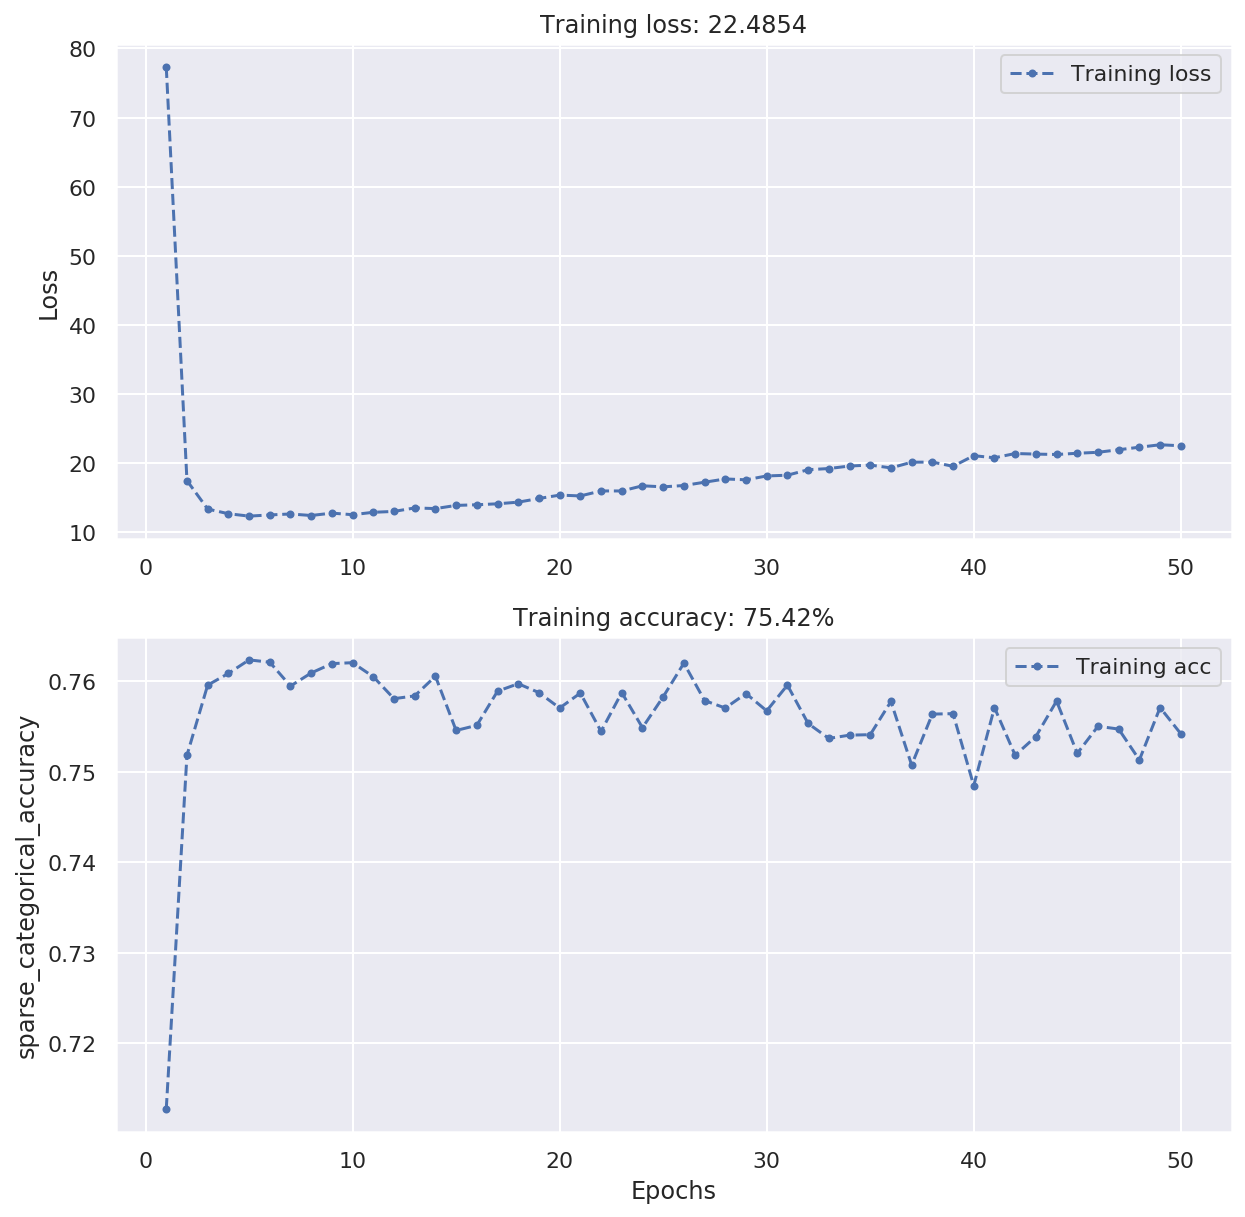

In [12]:
# Show training results
plot_loss_acc(history)

In [13]:
result = model.predict(X_test)
predictions = [np.argmax(result[i])for i in range(result.shape[0])]
print('result.shape',result.shape)
print('y_test.shape',y_test.shape)
print(confusion_matrix(y_test, predictions))
print(metrics.precision_score(y_test, predictions, average='weighted'))

print(metrics.recall_score(y_test, predictions, average='weighted'))
print(metrics.f1_score(y_test, predictions, average='weighted'))

result.shape (4842, 5)
y_test.shape (4842,)
[[   0  434    0    0    0]
 [   0 4232    0    2    0]
 [   0   79    0    0    0]
 [   0   71    0    0    0]
 [   0   24    0    0    0]]
0.7645860429233191
0.8740190004130525
0.8156483243881121


/home/orvath/anaconda3/envs/pfe/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/orvath/anaconda3/envs/pfe/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


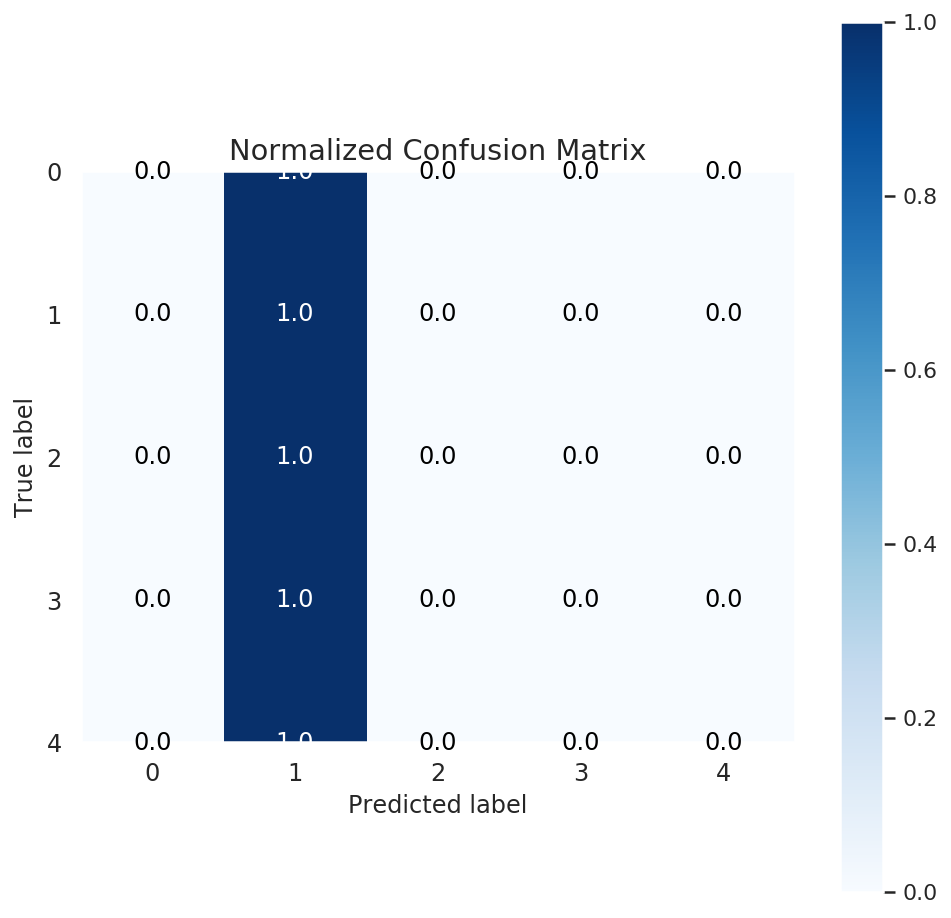

In [14]:
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()

In [15]:
result = model.evaluate(X_test, y_test, batch_size=128)

4842/4842 [==============================] - 0s 21us/sample - loss: 39.4862 - sparse_categorical_accuracy: 0.8740


### XGBoost

In [16]:
xgb2 = XGBClassifier(n_estimators=170, learning_rate=0.25)
histo_xgb = xgb2.fit(X_train, y_train)
print(xgb2.score(X_test, y_test))

0.9043783560512185


/home/orvath/anaconda3/envs/pfe/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [17]:
predictions_xgb = histo_xgb.predict(X_test)
print('predicted',predictions_xgb)
print('true label',y_test)

predicted [1 1 1 ... 1 1 0]
true label [1 1 1 ... 1 1 0]


/home/orvath/anaconda3/envs/pfe/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
print(confusion_matrix(y_test, predictions_xgb))
print(metrics.precision_score(y_test, predictions_xgb,
                              average='weighted'))

print(metrics.recall_score(y_test, predictions_xgb, average='weighted'))
print(metrics.f1_score(y_test, predictions_xgb, average='weighted'))

[[ 168  265    1    0    0]
 [  33 4193    8    0    0]
 [   0   62   16    1    0]
 [   7   62    0    2    0]
 [   2   22    0    0    0]]
0.8882947763876582
0.9043783560512185
0.8822886677745392


/home/orvath/anaconda3/envs/pfe/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/orvath/anaconda3/envs/pfe/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


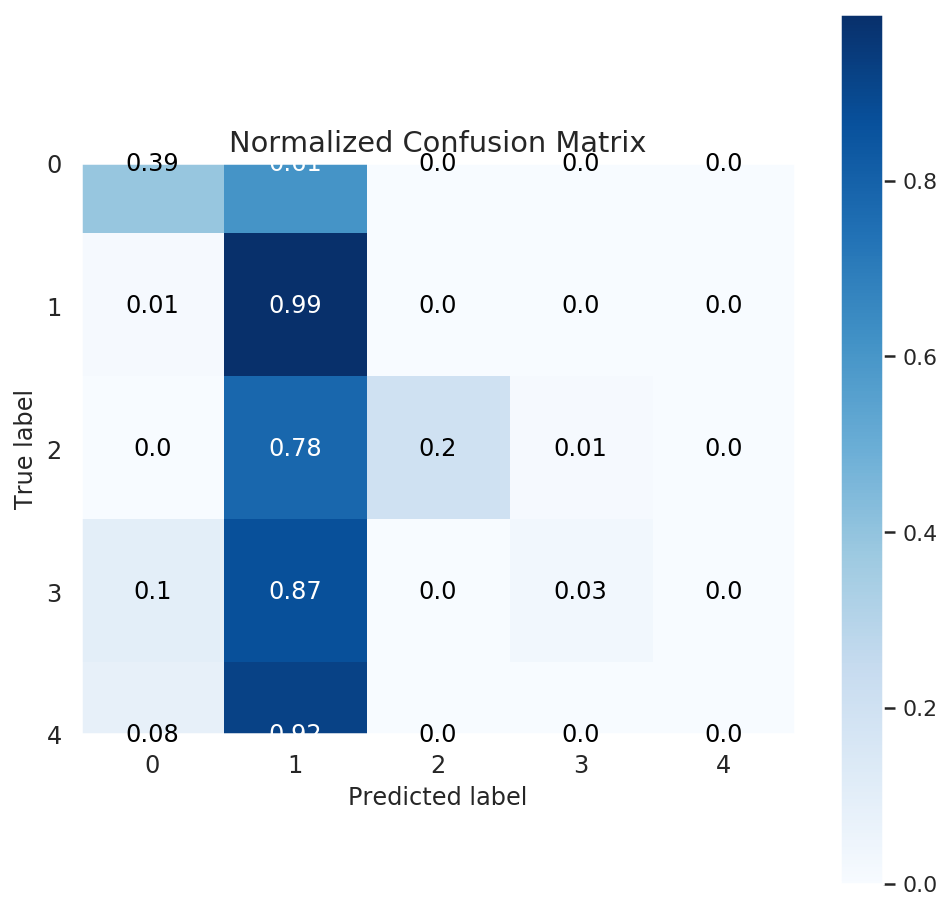

In [19]:
skplt.metrics.plot_confusion_matrix(y_test, predictions_xgb,
                                    normalize=True)
plt.show()

### GRU 

In [20]:
X1 = X_train.reshape(len(X_train), 9, 1)
input_shape = X1.shape[1:]
y1 = y_train.reshape(len(y_train), 1)
output_shape = len(y1)
model = tf.keras.Sequential()

model.add(layers.GRU(256, input_shape=input_shape,return_sequences=True))

model.add(layers.Dropout(0.5))
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(6, activation='softmax'))
opt = tfa.optimizers.RectifiedAdam(lr=1e-3)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
          loss=tf.keras.losses.sparse_categorical_crossentropy,
          metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 9, 256)            198912    
_________________________________________________________________
dropout (Dropout)            (None, 9, 256)            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 248,966
Trainable params: 248,966
Non-trainable params: 0
_________________________________________________________________


In [21]:
history_gru = model.fit(X1, y1, epochs=10, batch_size=600)

Train on 19364 samples
Epoch 1/10
19364/19364 [==============================] - 6s 326us/sample - loss: 0.5992 - sparse_categorical_accuracy: 0.8464
Epoch 2/10
19364/19364 [==============================] - 5s 235us/sample - loss: 0.4856 - sparse_categorical_accuracy: 0.8737
Epoch 3/10
19364/19364 [==============================] - 5s 234us/sample - loss: 0.4802 - sparse_categorical_accuracy: 0.8737
Epoch 4/10
19364/19364 [==============================] - 5s 242us/sample - loss: 0.4698 - sparse_categorical_accuracy: 0.8737
Epoch 5/10
19364/19364 [==============================] - 5s 238us/sample - loss: 0.4644 - sparse_categorical_accuracy: 0.8736
Epoch 6/10
19364/19364 [==============================] - 5s 249us/sample - loss: 0.4570 - sparse_categorical_accuracy: 0.8731
Epoch 7/10
19364/19364 [==============================] - 5s 256us/sample - loss: 0.4519 - sparse_categorical_accuracy: 0.8737
Epoch 8/10
19364/19364 [==============================] - 5s 255us/sample - loss: 0.4517

In [22]:
x_test = X_test.reshape(len(X_test), 9, 1)
Y_test = y_test.reshape(len(y_test), 1)
result_gru = model.predict(x_test)
predictions_gru = [np.argmax(result_gru[i])for i in range(result_gru.shape[0])]
print('predicted',len(predictions_gru))
print('true label',len(Y_test))

predicted 4842
true label 4842


In [23]:
print(confusion_matrix(Y_test, predictions_gru))
print('precision_score:',metrics.precision_score(Y_test, predictions_gru,
                              average='weighted'))

print('recall_score:',metrics.recall_score(Y_test, predictions_gru, average='weighted'))
print('f1_score:',metrics.f1_score(Y_test, predictions_gru, average='weighted'))

[[   0  434    0    0    0]
 [   0 4234    0    0    0]
 [   0   79    0    0    0]
 [   0   71    0    0    0]
 [   0   24    0    0    0]]
precision_score: 0.7646314150876922
recall_score: 0.8744320528707146
f1_score: 0.8158539691173657


/home/orvath/anaconda3/envs/pfe/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/orvath/anaconda3/envs/pfe/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


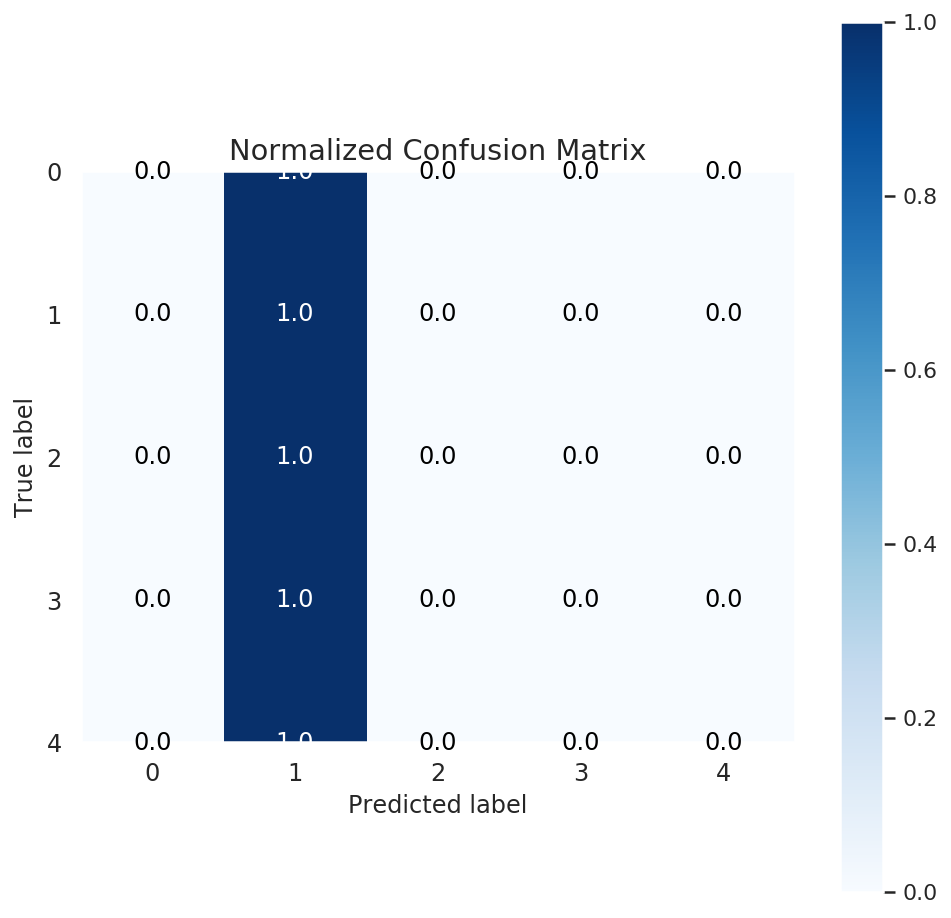

In [24]:
skplt.metrics.plot_confusion_matrix(Y_test, predictions_gru,
                                    normalize=True)
plt.show()

### LSTM

In [25]:
X = X_train.reshape(len(X_train), 9, 1)
y = y_train.reshape(len(y_train), 1)
# define model
model = tf.keras.Sequential()
model.add(layers.LSTM(30, input_shape=(9, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(6))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

opt = tfa.optimizers.RectifiedAdam(lr=1e-3)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
          loss=tf.keras.losses.sparse_categorical_crossentropy,
          metrics=['sparse_categorical_accuracy'])
model.summary()
# fit model
history = model.fit(X, y, epochs=15, batch_size=1000, verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3840      
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 186       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 42        
Total params: 4,188
Trainable params: 4,128
Non-trainable params: 60
_________________________________________________________________
Train on 19364 samples
Epoch 1/15
19364/19364 - 2s - loss: 1.8577 - sparse_categorical_accuracy: 0.2484
Epoch 2/15
19

In [26]:
# evaluate model on new data
x_test = X_test.reshape(len(X_test), 9, 1)
Y_test = y_test.reshape(len(y_test), 1)
result_lstm = model.predict(x_test)
predictions_lstm = [np.argmax(result_lstm[i])for i in range(result_lstm.shape[0])]
print('predicted',len(predictions_lstm))
print('true label',len(Y_test))

predicted 4842
true label 4842


In [27]:
print(confusion_matrix(Y_test, predictions_lstm))
print('precision_score',metrics.precision_score(Y_test, predictions_lstm, average='weighted'))

print('recall_score:',metrics.recall_score(Y_test, predictions_lstm, average='weighted'))
print('f1_score:',metrics.f1_score(Y_test, predictions_lstm, average='weighted'))

[[   0  434    0    0    0]
 [   0 4234    0    0    0]
 [   0   79    0    0    0]
 [   0   71    0    0    0]
 [   0   24    0    0    0]]
precision_score 0.7646314150876922
recall_score: 0.8744320528707146
f1_score: 0.8158539691173657


/home/orvath/anaconda3/envs/pfe/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/orvath/anaconda3/envs/pfe/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


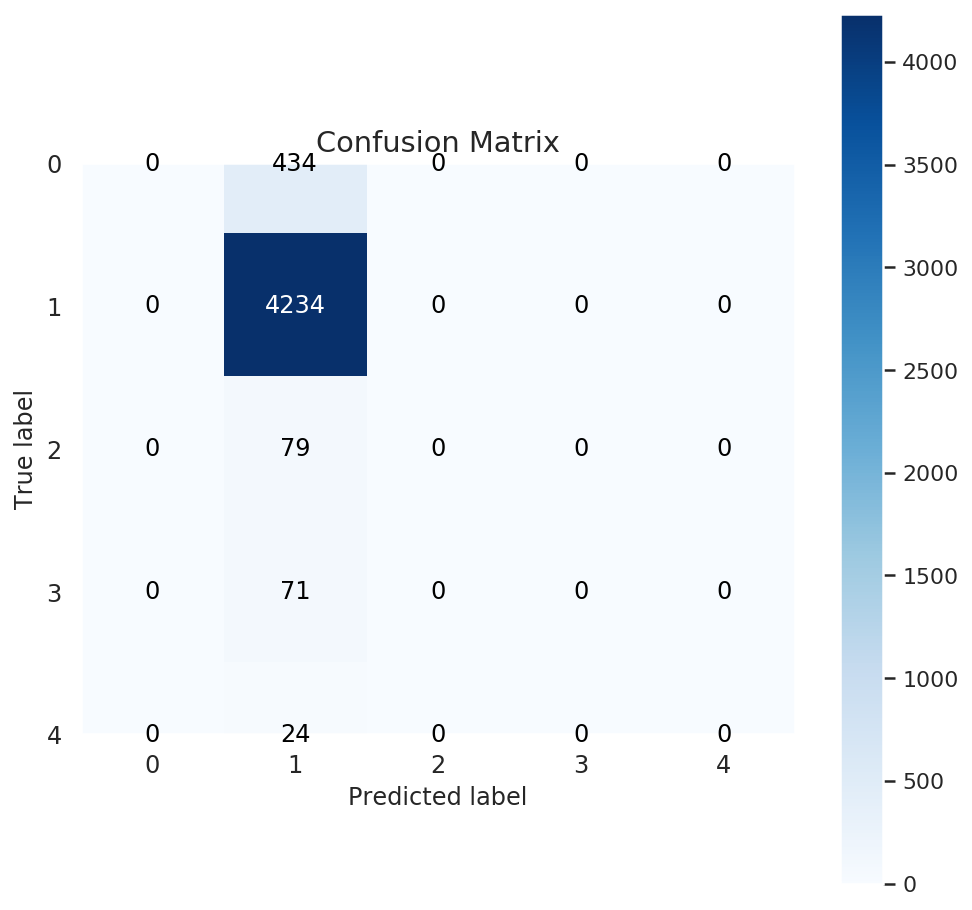

In [28]:
skplt.metrics.plot_confusion_matrix(Y_test, predictions_lstm,
                                    normalize=False)
plt.show()

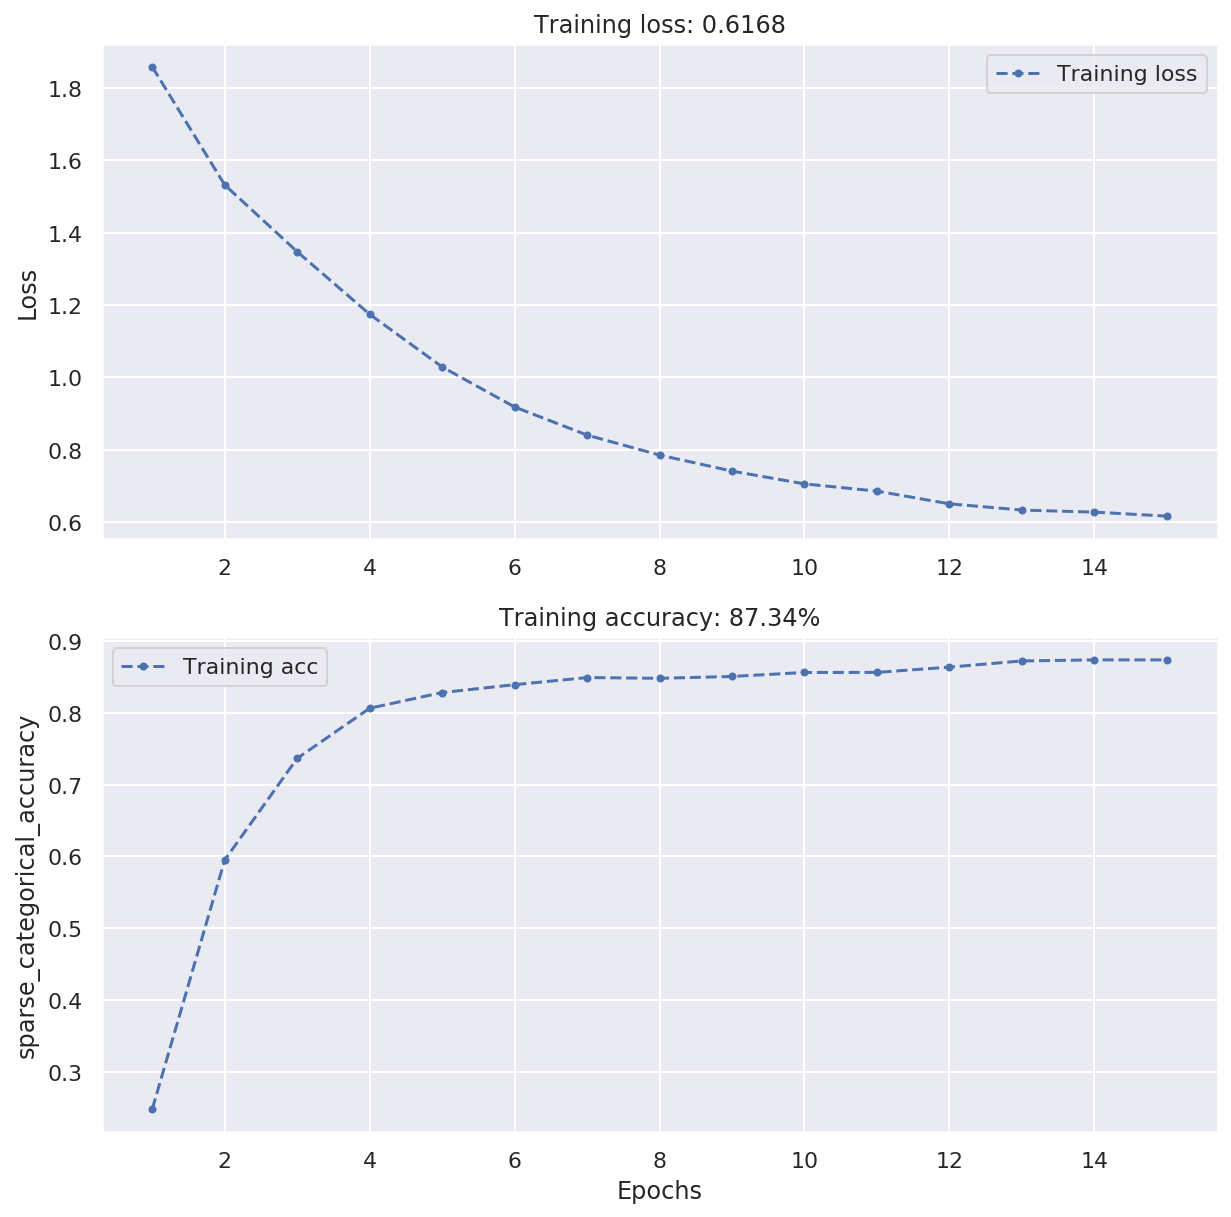

In [29]:
plot_loss_acc(history)